# Influence Analysis on MNIST

## Setup 

In [1]:
import argparse
import logging
import os
from typing import Tuple
from typing import Literal

import torch
import torch.nn.functional as F
from torch import nn
import torchvision

from kronfluence.analyzer import Analyzer, prepare_model
from kronfluence.arguments import FactorArguments, ScoreArguments
from kronfluence.task import Task
from kronfluence.utils.common.factor_arguments import all_low_precision_factor_arguments
from kronfluence.utils.common.score_arguments import all_low_precision_score_arguments
from kronfluence.utils.dataset import DataLoaderKwargs
from examples.mnist.pipeline import get_mnist_dataset, construct_mnist_classifier
import numpy as np
from matplotlib import pyplot as plt
from typing import Sequence

## Analysis

### Task

In [2]:
BATCH_TYPE = Tuple[torch.Tensor, torch.Tensor]


class ClassificationTask(Task):
    def compute_train_loss(
        self,
        batch: BATCH_TYPE,
        model: nn.Module,
        sample: bool = False,
    ) -> torch.Tensor:
        inputs, labels = batch
        logits = model(inputs)
        if not sample:
            return F.cross_entropy(logits, labels, reduction="sum")
        with torch.no_grad():
            probs = torch.nn.functional.softmax(logits.detach(), dim=-1)
            sampled_labels = torch.multinomial(
                probs,
                num_samples=1,
            ).flatten()
        return F.cross_entropy(logits, sampled_labels, reduction="sum")

    def compute_measurement(
        self,
        batch: BATCH_TYPE,
        model: nn.Module,
    ) -> torch.Tensor:
        # Copied from: https://github.com/MadryLab/trak/blob/main/trak/modelout_functions.py. Returns the margin between the correct logit and the second most likely prediction
        inputs, labels = batch
        logits = model(inputs)

        # Get correct logit values
        bindex = torch.arange(logits.shape[0]).to(device=logits.device, non_blocking=False)
        logits_correct = logits[bindex, labels]

        # Get the other logits, and take the softmax of them
        cloned_logits = logits.clone()
        cloned_logits[bindex, labels] = torch.tensor(-torch.inf, device=logits.device, dtype=logits.dtype)
        maximum_non_correct_logits = cloned_logits.logsumexp(dim=-1)

        # Look at the  margin, the difference between the correct logits and the (soft) maximum non-correctl logits
        margins = logits_correct - maximum_non_correct_logits
        return -margins.sum()

## Analysis

In [3]:
dataset_dir = "/h/maxk/kronfluence/data"
output_dir = "/h/maxk/kronfluence/examples/mnist/influence_results"
model_path = "/h/maxk/kronfluence/checkpoints/model.pth"
factor_strategy: Literal["identity", "diagonal", "kfac", "ekfac"] = "ekfac"  # TODO: Add typesc for the
profile_computations = False
use_half_precision = False
query_batch_size = 1500

In [4]:
# Prepare the dataset.
train_dataset = get_mnist_dataset(split="eval_train", dataset_dir=dataset_dir, in_memory=False)
eval_dataset = get_mnist_dataset(split="test", dataset_dir=output_dir, in_memory=False)

# Prepare the trained model.
model = construct_mnist_classifier()
model.load_state_dict(torch.load(model_path))

# Define task and prepare model.
task = ClassificationTask()
model = prepare_model(model, task)

analyzer = Analyzer(
    analysis_name="mnist",
    model=model,
    task=task,
    output_dir=output_dir,
    profile=profile_computations,
)
# Configure parameters for DataLoader.
dataloader_kwargs = DataLoaderKwargs(num_workers=4)
analyzer.set_dataloader_kwargs(dataloader_kwargs)

In [5]:
# Compute influence factors.
factors_name = factor_strategy
factor_args = FactorArguments(strategy=factor_strategy)
if use_half_precision:
    factor_args = all_low_precision_factor_arguments(strategy=factor_strategy, dtype=torch.bfloat16)
    factors_name += "_half"

analyzer.fit_all_factors(
    factors_name=factors_name,
    factor_args=factor_args,
    dataset=train_dataset,
    per_device_batch_size=None,
    overwrite_output_dir=False,
)

# Compute pairwise scores.
score_args = ScoreArguments()
scores_name = factor_args.strategy

if use_half_precision:
    score_args = all_low_precision_score_arguments(dtype=torch.bfloat16)
    scores_name += "_half"

analyzer.compute_pairwise_scores(
    scores_name=scores_name,
    score_args=score_args,
    factors_name=factors_name,
    query_dataset=eval_dataset,
    query_indices=list(range(2000)),
    train_dataset=train_dataset,
    per_device_query_batch_size=query_batch_size,
    overwrite_output_dir=False,
)

In [13]:
scores_dict = analyzer.load_pairwise_scores(scores_name)
scores_dict["all_modules"].shape

torch.Size([2000, 60000])

In [38]:
def plot_most_influencial_images(
    influence_scores: torch.Tensor,
    test_dataset: torchvision.datasets.MNIST,
    train_dataset: torchvision.datasets.MNIST,
    num_images: int = 5,
    top_k: int = 3,
    test_dataset_subset: Sequence[int] | None = None,
):
    test_dataset_data = test_dataset.data
    if test_dataset_subset is not None:
        influence_scores = influence_scores[test_dataset_subset]
        test_dataset_data = test_dataset.data[test_dataset_subset]

    images_of_interest = test_dataset_data[:num_images]
    for image_idx, image in enumerate(images_of_interest):
        most_influencial_examples = torch.argsort(influence_scores[image_idx], descending=True)[:top_k]

        fig, ax = plt.subplots(ncols=top_k + 1, figsize=(5 * (top_k + 1), 5))
        ax[0].imshow(image, cmap="gray")
        for i, idx in enumerate(most_influencial_examples):
            ax[i + 1].imshow(train_dataset.data[idx], cmap="gray")
            ax[i + 1].set_title(f"Example {idx}")
        plt.show()

(array([   3,   10,   13,   25,   28,   55,   69,   71,  101,  126,  136,
         148,  157,  183,  188,  192,  194,  215,  246,  269,  271,  294,
         296,  297,  305,  311,  312,  324,  327,  346,  365,  372,  380,
         407,  424,  440,  441,  443,  459,  485,  490,  498,  525,  545,
         546,  552,  561,  564,  567,  581,  586,  592,  597,  608,  611,
         620,  642,  644,  656,  661,  701,  704,  713,  717,  721,  723,
         742,  750,  763,  794,  804,  821,  845,  851,  854,  871,  884,
         895,  896,  904,  932,  972,  981,  993,  997, 1001, 1009, 1034,
        1047, 1061, 1084, 1094, 1121, 1148, 1154, 1176, 1188, 1191, 1195,
        1197, 1203, 1218, 1220, 1223, 1231, 1246, 1261, 1271, 1273, 1288,
        1294, 1297, 1333, 1379, 1390, 1399, 1404, 1408, 1411, 1416, 1438,
        1445, 1454, 1457, 1468, 1487, 1504, 1517, 1526, 1533, 1534, 1535,
        1558, 1565, 1570, 1589, 1590, 1610, 1619, 1621, 1623, 1638, 1650,
        1692, 1700, 1708, 1712, 1713, 

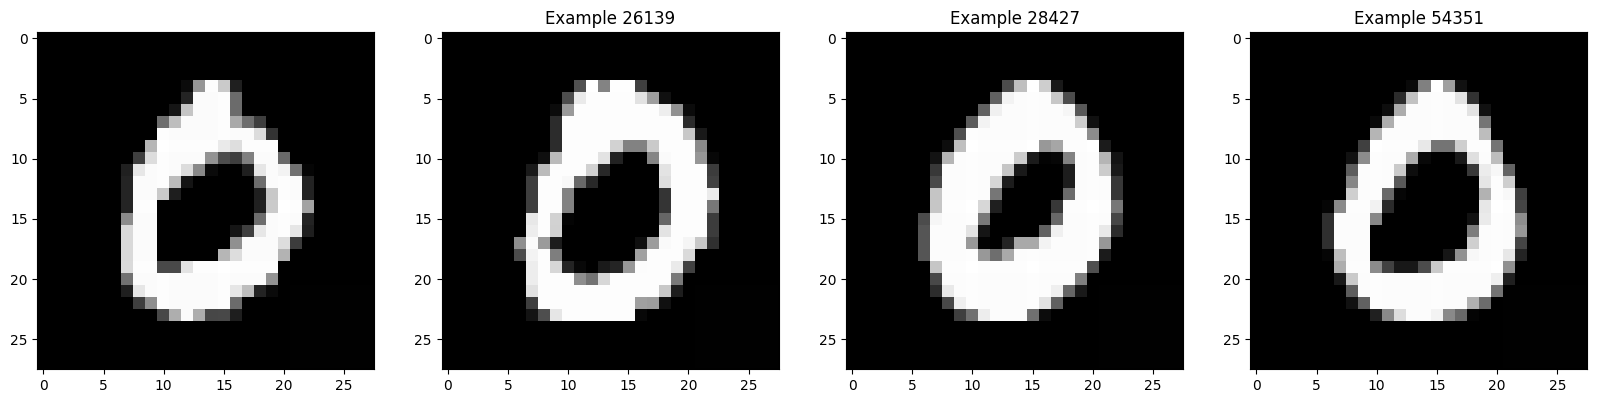

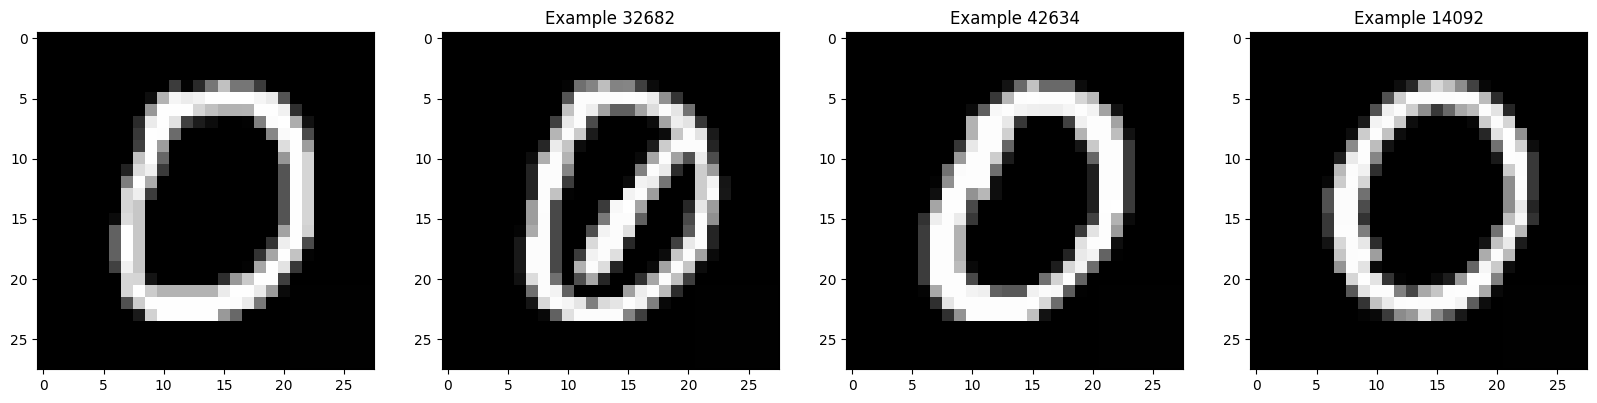

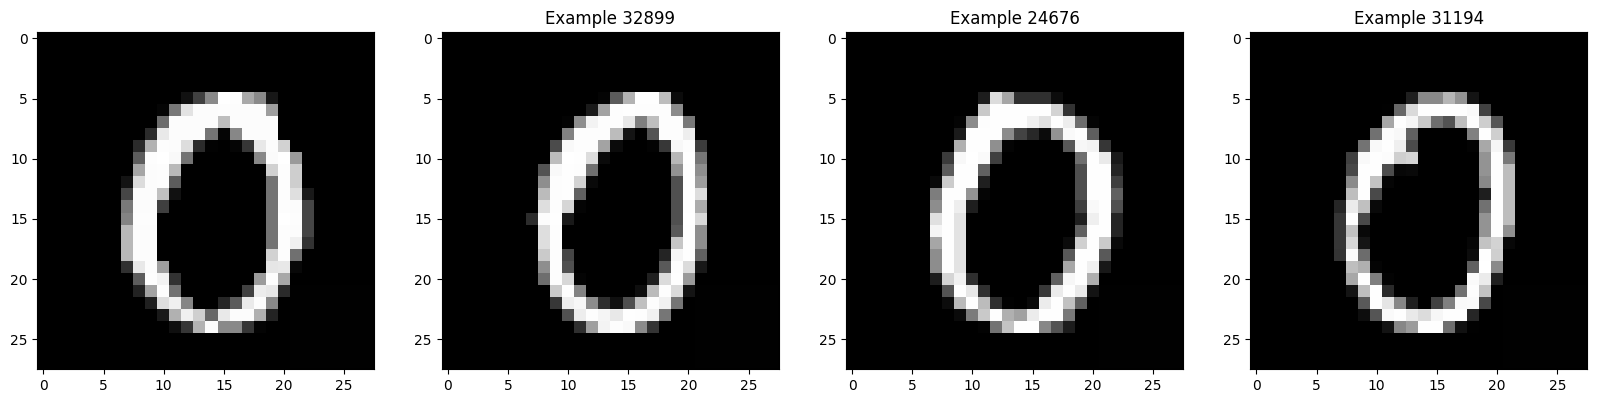

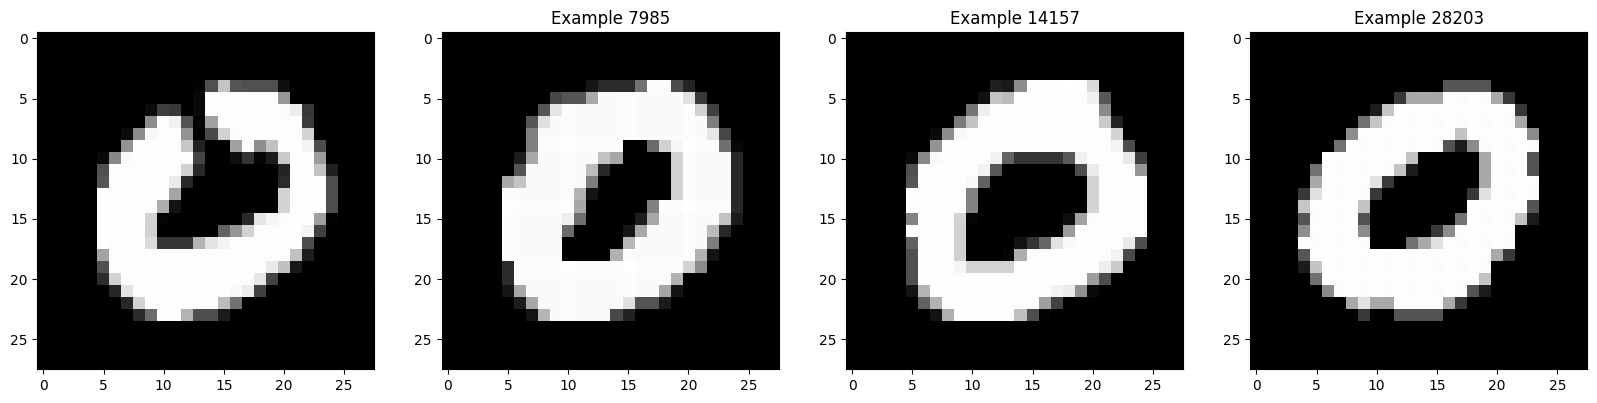

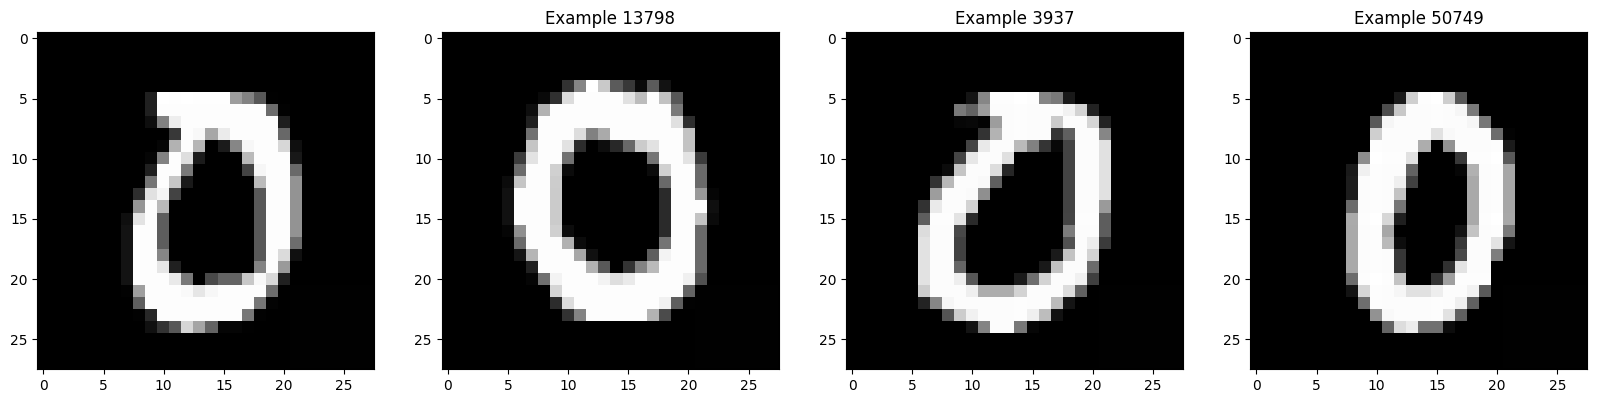

In [56]:
plot_most_influencial_images(scores_dict["all_modules"], eval_dataset, train_dataset, num_images=5, top_k=3, test_dataset_subset=np.where(eval_dataset.targets[:2000] == 0)[0])

In [57]:
train_dataset_in_memory = get_mnist_dataset(split="eval_train", dataset_dir=dataset_dir, in_memory=True)
eval_dataset_in_memory = get_mnist_dataset(split="test", dataset_dir=output_dir, in_memory=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9.91M/9.91M [00:00<00:00, 52.9MB/s]


Extracting /h/maxk/kronfluence/examples/mnist/influence_results/InMemoryMNIST/raw/train-images-idx3-ubyte.gz to /h/maxk/kronfluence/examples/mnist/influence_results/InMemoryMNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28.9k/28.9k [00:00<00:00, 1.72MB/s]


Extracting /h/maxk/kronfluence/examples/mnist/influence_results/InMemoryMNIST/raw/train-labels-idx1-ubyte.gz to /h/maxk/kronfluence/examples/mnist/influence_results/InMemoryMNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.65M/1.65M [00:00<00:00, 3.55MB/s]


Extracting /h/maxk/kronfluence/examples/mnist/influence_results/InMemoryMNIST/raw/t10k-images-idx3-ubyte.gz to /h/maxk/kronfluence/examples/mnist/influence_results/InMemoryMNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4.54k/4.54k [00:00<00:00, 3.25MB/s]

Extracting /h/maxk/kronfluence/examples/mnist/influence_results/InMemoryMNIST/raw/t10k-labels-idx1-ubyte.gz to /h/maxk/kronfluence/examples/mnist/influence_results/InMemoryMNIST/raw



In [59]:
train_dataset_in_memory[0]

TypeError: Input tensor should be a float tensor. Got torch.uint8.